In [ ]:
import random as rnd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bluebikes_analysis.config import LOCAL_DATA_DIR
from bluebikes_analysis.plots import (
    COLORS,
    plot_daily_longterm,
    plot_hourly_weekly,
    plot_points_on_map,
)

### Explore hourly time series

In [2]:
# Get base folder and csv filenames
csv_folder = LOCAL_DATA_DIR / "interim/trip_aggregates"
csv_file = "hourly_station_aggregates.csv"

df_hourly = pd.read_csv(csv_folder / csv_file)

In [3]:
# Get base folder and csv filenames
csv_folder = LOCAL_DATA_DIR / "raw/stations"
csv_file = "station_information.csv"

df_stations = pd.read_csv(csv_folder / csv_file)

Merge data without differenceing member - casual or ebike - classic

In [4]:
# Create timestamp and aggregate by station
df_hourly['timestamp'] = pd.to_datetime(df_hourly['date']) + pd.to_timedelta(df_hourly['hour'], unit='h')

station_df_dict = {
    station_id: group.groupby('timestamp')[['pickups', 'dropoffs']].sum().reset_index().sort_values('timestamp')
    for station_id, group in df_hourly.groupby('station_id')
}

In [5]:
# Reindex to fill missing hours with 0 (assuming missing = no activity)
for station_id in station_df_dict:
    df = station_df_dict[station_id].set_index('timestamp')
    
    # Create complete hourly range
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
    
    # Reindex and fill missing with 0
    df = df.reindex(full_range, fill_value=0).reset_index()
    df.columns = ['timestamp', 'pickups', 'dropoffs']
    
    station_df_dict[station_id] = df

---

Plotting the stations of interest

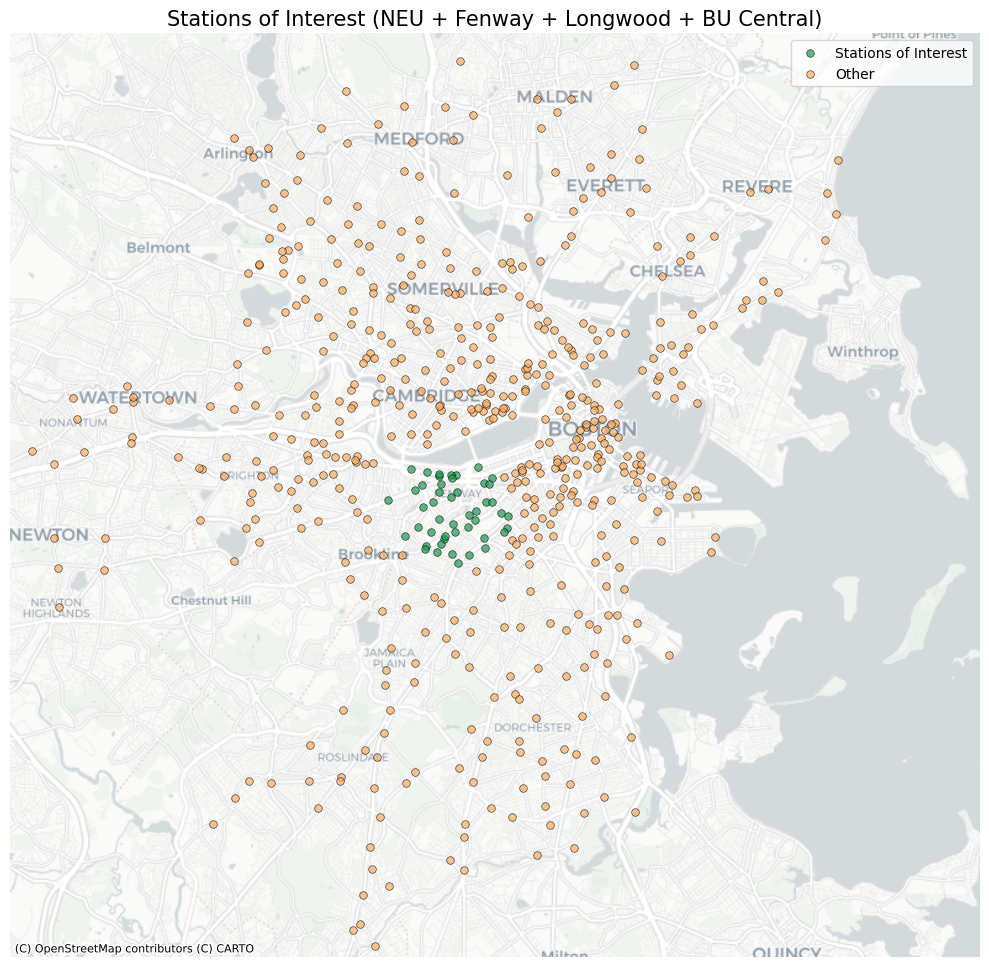

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Stations of Interest (NEU + Fenway + Longwood + BU Central)'}>)

In [6]:
# Example: Focus on downtown Boston / Back Bay area
bbox = (-71.22, 42.25, -70.95, 42.44)

selected = list(df_hourly["station_id"].unique())
non_selected = [x for x in df_stations["short_name"].unique() if x not in selected]

plot_points_on_map(
    df_stations,
    lat_col='lat',
    lon_col='lon',
    label_col='short_name',
    group_col='short_name',
    group_values=[selected, non_selected],
    color_list=[COLORS[5], COLORS[2]],
    bbox=bbox,
    legend_labels=["Stations of Interest", "Other"],
    title="Stations of Interest (NEU + Fenway + Longwood + BU Central)",
    show_labels=True,
    markersize_list=[30],
    figsize=(10,10)
)

---

### Exploratory Analysis of a single station

We are interested in forecasting morning demand for each of th stations, so lets explore that pattern.

In [7]:
# Get one fo the time series at random
rnd.seed(42)
rnd_idx = rnd.randint(1, len(station_df_dict))

rnd_station_id = list(station_df_dict.keys())[0] # Get first station
rnd_station_df = station_df_dict[rnd_station_id]

In [8]:
# Aggregate to daily level
rnd_station_daily = rnd_station_df.copy()
rnd_station_daily['date'] = rnd_station_daily['timestamp'].dt.date
rnd_station_daily = rnd_station_daily.groupby('date')[['pickups', 'dropoffs']].sum().reset_index()
rnd_station_daily = rnd_station_daily.set_index('date')

In [9]:
rnd_station_daily.head()

pickups  dropoffs
date                         
2023-04-01       44        44
2023-04-02       42        39
2023-04-03       60        55
2023-04-04       63        64
2023-04-05       35        28

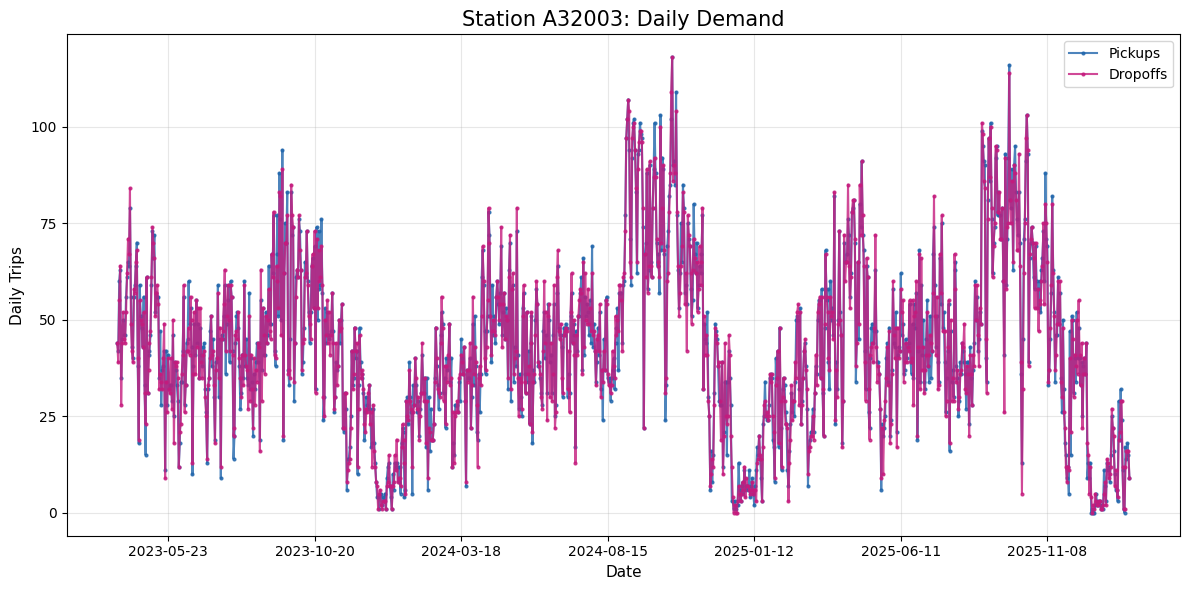

In [10]:
plot_daily_longterm(
    rnd_station_daily,
    columns_to_plot=['pickups', 'dropoffs'],
    title=f'Station {rnd_station_id}: Daily Demand',
    xlabel='Date',
    ylabel='Daily Trips',
    color_list=[COLORS[7], COLORS[1]],
    legend_labels=['Pickups', 'Dropoffs']
)

It is difficult to see any pattern different what we have already seen in the total trips. This is because stations tend to perform differently within a single day (different hourly patterns based on location: residential vs commercial areas). So lets calculate the mean trips per hour across weeks for each of the stations in hour dataset.

In [11]:
def create_weekly_profile(station_df):
    """
    Create average weekly profile: mean demand for each hour of the week.
    """
    df = station_df.copy()
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['hour'] = df['timestamp'].dt.hour
    
    # Average across all instances of "Monday 8am", "Tuesday 3pm", etc.
    weekly_profile = df.groupby(['dayofweek', 'hour']).agg({
        'pickups': 'mean',
        'dropoffs': 'mean'
    }).reset_index()
    
    weekly_profile.columns = ['dayofweek', 'hour', 'avg_pickups', 'avg_dropoffs']
    
    # Create hour_of_week index (0-167)
    weekly_profile = weekly_profile.sort_values(['dayofweek', 'hour'])
    weekly_profile['hour_of_week'] = range(len(weekly_profile))
    weekly_profile = weekly_profile.set_index('hour_of_week')
    
    return weekly_profile


# Create profiles for all stations
weekly_df_dict = {}
for station_id, df in station_df_dict.items():
    weekly_df_dict[station_id] = create_weekly_profile(df)

In [12]:
rnd_weekly_df = weekly_df_dict[rnd_station_id]

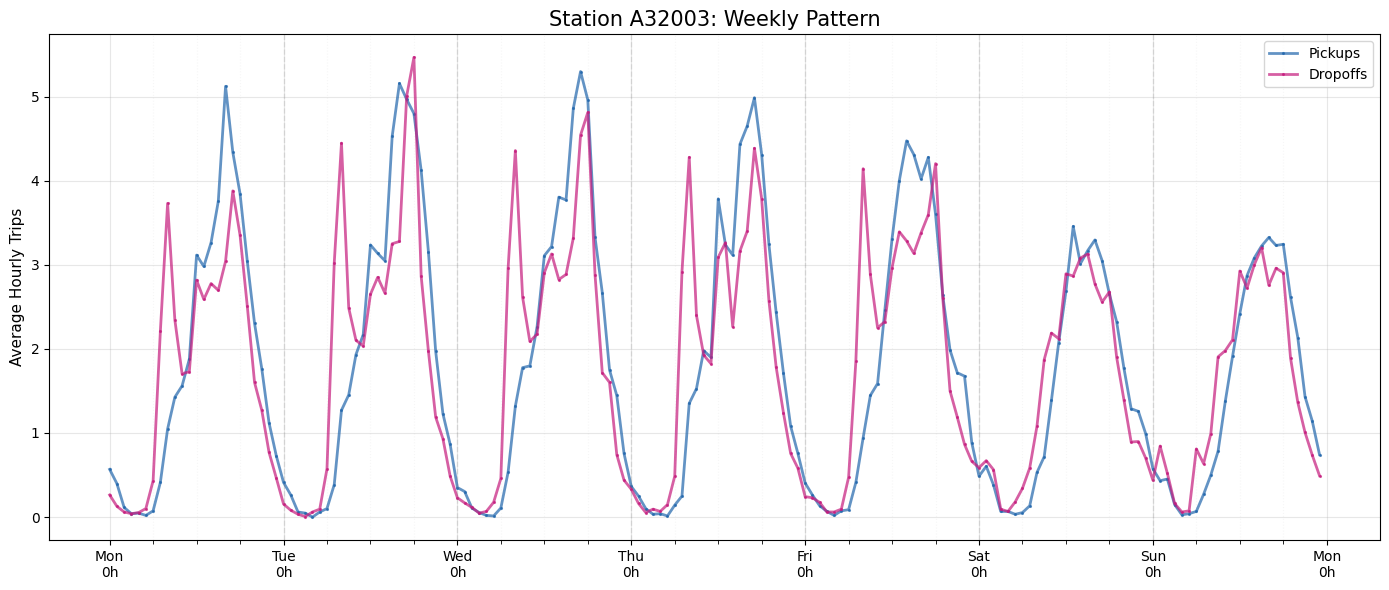

In [13]:
plot_hourly_weekly(
    rnd_weekly_df,
    columns_to_plot=['avg_pickups', 'avg_dropoffs'],
    title=f'Station {rnd_station_id}: Weekly Pattern',
    ylabel='Average Hourly Trips',
    color_list=[COLORS[7], COLORS[1]],
    legend_labels=['Pickups', 'Dropoffs']
)

We can see that for this random station the pickups and dropoffs have close but essentially different patters. Particularly, at morning hours the drop offs demand is muich higher than the pick up demand, probably due to its proximity to offices, or educational centers.

---

Now we wonder. Are all the stations in our selection behaving the same? Can we see observe different patterns? Lets cluster the stations based on their weekly profile to find that.

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt


def compute_station_distance_matrix(
    station_profiles, metric="both", distance_type="euclidean", normalization="minmax"
):
    """
    Compute pairwise distance matrix between station weekly profiles.

    Parameters:
    -----------
    station_profiles : dict
        Dictionary mapping station_id to weekly profile DataFrame
    metric : str
        'pickups', 'dropoffs', or 'both' (joint 2D pattern)
    distance_type : str
        'euclidean' or 'manhattan'
    normalization : str
        'minmax' (scale each station to [0,1]) or 'standard' (z-score)

    Returns:
    --------
    distance_matrix : np.ndarray
        Symmetric distance matrix
    station_ids : list
        Ordered list of station IDs
    """
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    from scipy.spatial.distance import pdist, squareform

    station_ids = list(station_profiles.keys())
    n_stations = len(station_ids)

    # Extract and normalize profiles
    if metric == "both":
        # Treat as joint (pickups, dropoffs) pattern
        features = []
        for station_id in station_ids:
            profile = station_profiles[station_id].sort_values(["dayofweek", "hour"])
            # Interleave pickups and dropoffs: [p0, d0, p1, d1, ...]
            pickups = profile["avg_pickups"].values
            dropoffs = profile["avg_dropoffs"].values

            if normalization == "minmax":
                # Normalize each separately to [0, 1]
                pickups_norm = (pickups - pickups.min()) / (pickups.max() - pickups.min() + 1e-8)
                dropoffs_norm = (dropoffs - dropoffs.min()) / (
                    dropoffs.max() - dropoffs.min() + 1e-8
                )
            elif normalization == "standard":
                pickups_norm = (pickups - pickups.mean()) / (pickups.std() + 1e-8)
                dropoffs_norm = (dropoffs - dropoffs.mean()) / (dropoffs.std() + 1e-8)
            else:
                raise ValueError("normalization must be 'minmax' or 'standard'")

            # Combine into 336-dimensional vector
            combined = np.empty(2 * len(pickups))
            combined[0::2] = pickups_norm
            combined[1::2] = dropoffs_norm
            features.append(combined)

        features = np.array(features)

        # Compute pairwise distances
        if distance_type == "euclidean":
            distance_matrix = squareform(pdist(features, metric="euclidean"))
        elif distance_type == "manhattan":
            distance_matrix = squareform(pdist(features, metric="cityblock"))
        else:
            raise ValueError("distance_type must be 'euclidean' or 'manhattan'")

    else:
        # Separate pickups or dropoffs only
        features = []
        for station_id in station_ids:
            profile = station_profiles[station_id].sort_values(["dayofweek", "hour"])
            if metric == "pickups":
                values = profile["avg_pickups"].values
            else:
                values = profile["avg_dropoffs"].values

            if normalization == "minmax":
                values_norm = (values - values.min()) / (values.max() - values.min() + 1e-8)
            elif normalization == "standard":
                values_norm = (values - values.mean()) / (values.std() + 1e-8)
            else:
                raise ValueError("normalization must be 'minmax' or 'standard'")

            features.append(values_norm)

        features = np.array(features)

        if distance_type == "euclidean":
            distance_matrix = squareform(pdist(features, metric="euclidean"))
        elif distance_type == "manhattan":
            distance_matrix = squareform(pdist(features, metric="cityblock"))

    print(f"Computed {distance_type} distance matrix for {n_stations} stations")
    print(f"Using metric: {metric}, normalization: {normalization}")

    return distance_matrix, station_ids


def cluster_stations_hierarchical(
    distance_matrix, station_ids, n_clusters=None, method="ward", plot_dendrogram=True
):
    """
    Perform hierarchical clustering on distance matrix.

    Parameters:
    -----------
    distance_matrix : np.ndarray
        Pairwise distance matrix
    station_ids : list
        Station IDs corresponding to matrix
    n_clusters : int, optional
        Number of clusters to cut at. If None, shows dendrogram to decide
    method : str
        Linkage method: 'ward', 'average', 'complete', 'single'
    plot_dendrogram : bool
        Whether to plot dendrogram

    Returns:
    --------
    cluster_map : dict
        Mapping of station_id to cluster label
    linkage_matrix : np.ndarray
        Linkage matrix for further analysis
    """
    # Convert to condensed distance matrix (required for linkage)
    condensed_dist = squareform(distance_matrix)

    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_dist, method=method)

    # Plot dendrogram
    if plot_dendrogram:
        plt.figure(figsize=(14, 7))
        dendrogram(linkage_matrix, labels=station_ids, leaf_font_size=8)
        plt.title(
            f"Hierarchical Clustering Dendrogram ({method} linkage)",
            fontsize=14,
            fontweight="bold",
        )
        plt.xlabel("Station ID", fontsize=11)
        plt.ylabel("DTW Distance", fontsize=11)
        plt.xticks(rotation=90)

        if n_clusters is not None:
            # Draw horizontal line at cut height
            threshold = linkage_matrix[-n_clusters + 1, 2]
            plt.axhline(
                y=threshold, color="r", linestyle="--", label=f"Cut for {n_clusters} clusters"
            )
            plt.legend()

        plt.tight_layout()
        plt.show()

    # Cut tree if n_clusters specified
    if n_clusters is not None:
        cluster_labels = fcluster(linkage_matrix, n_clusters, criterion="maxclust")
        cluster_map = {
            station_id: int(label - 1) for station_id, label in zip(station_ids, cluster_labels)
        }
        return cluster_map, linkage_matrix
    else:
        return None, linkage_matrix

In [15]:
# Fast Euclidean distance
distance_matrix, station_ids = compute_station_distance_matrix(
    weekly_df_dict, 
    metric='both',  # Joint (pickups, dropoffs) pattern
    distance_type='euclidean',
    normalization='minmax'  # Scale to [0, 1] per station
)

Computed euclidean distance matrix for 47 stations
Using metric: both, normalization: minmax


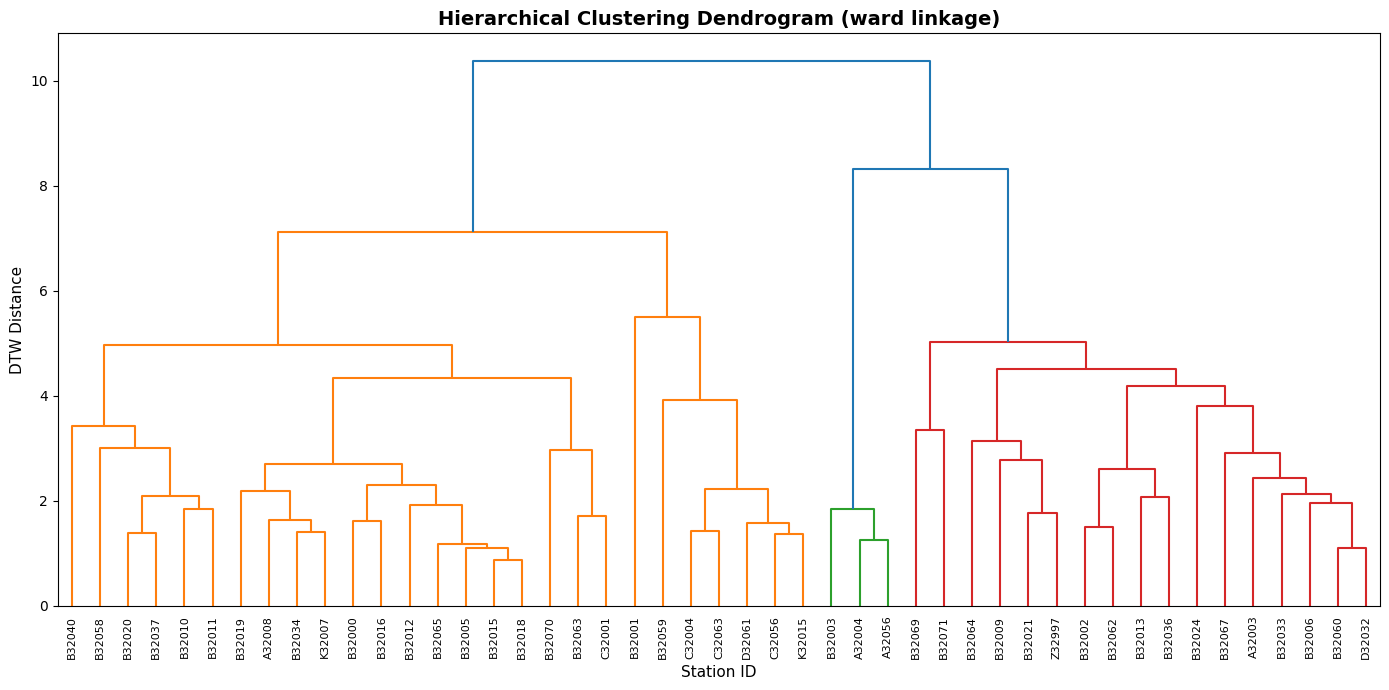

In [16]:
# Step 2: View dendrogram to choose number of clusters
_, linkage_mat = cluster_stations_hierarchical(
    distance_matrix, 
    station_ids,
    plot_dendrogram=True
)

In [17]:
# Step 3: Cut at desired number of clusters (based on dendrogram)
clusters, _ = cluster_stations_hierarchical(
    distance_matrix,
    station_ids,
    n_clusters=4,  # Adjust based on dendrogram
    plot_dendrogram=False
)

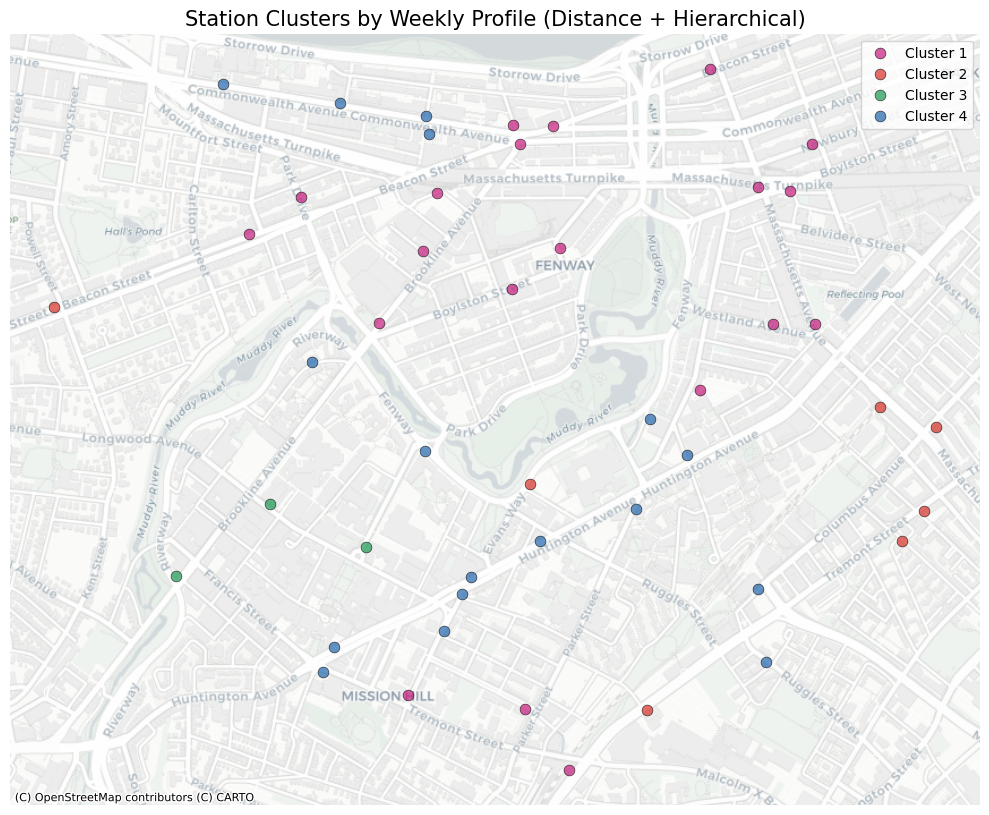

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Station Clusters by Weekly Profile (Distance + Hierarchical)'}>)

In [18]:
# Visualize clusters on map

bbox = (-71.12, 42.325, -71.07, 42.365)
n_clusters = len(set(clusters.values()))

stations_per_cluster_list = []
for idx in range(n_clusters):
    cluster_stations = [sid for sid, cid in clusters.items() if cid == idx]
    stations_per_cluster_list.append(cluster_stations)

plot_points_on_map(
    df_stations,
    group_col="short_name",
    group_values=stations_per_cluster_list,
    color_list=[COLORS[1], COLORS[3], COLORS[5], COLORS[7]],
    legend_labels=["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"],
    title="Station Clusters by Weekly Profile (Distance + Hierarchical)",
    show_labels=True,
    markersize_list=[60],
    zoom=15,
    figsize=(10, 10),
)

---

Lets plot an example of each of the clusters

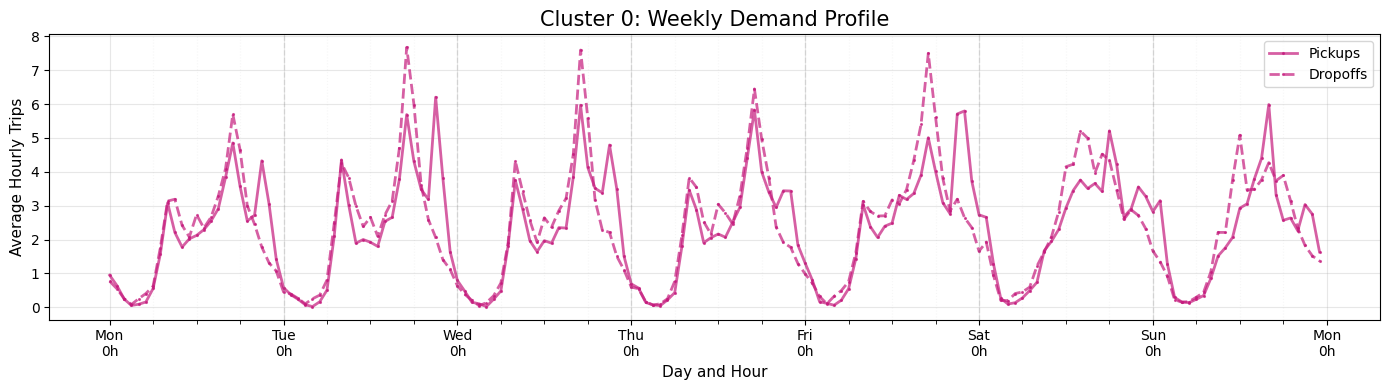

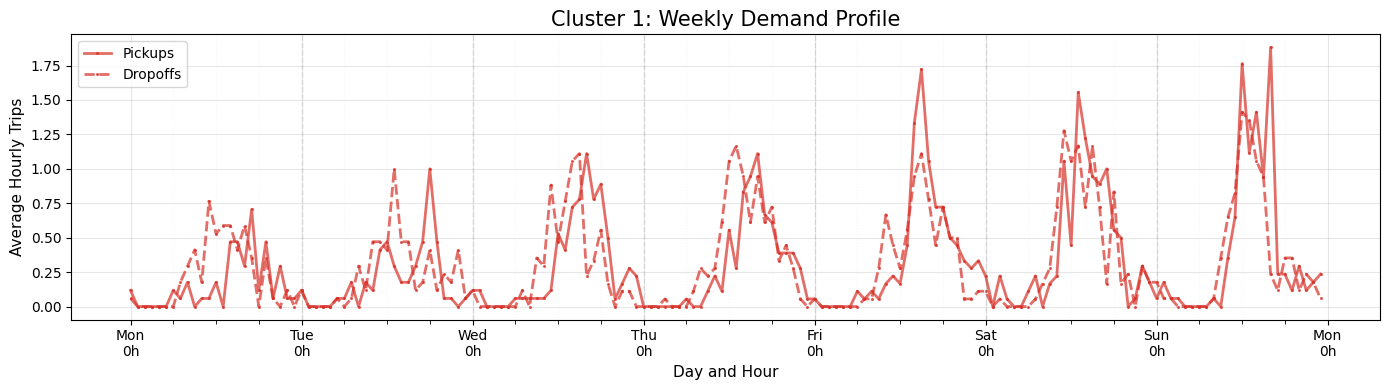

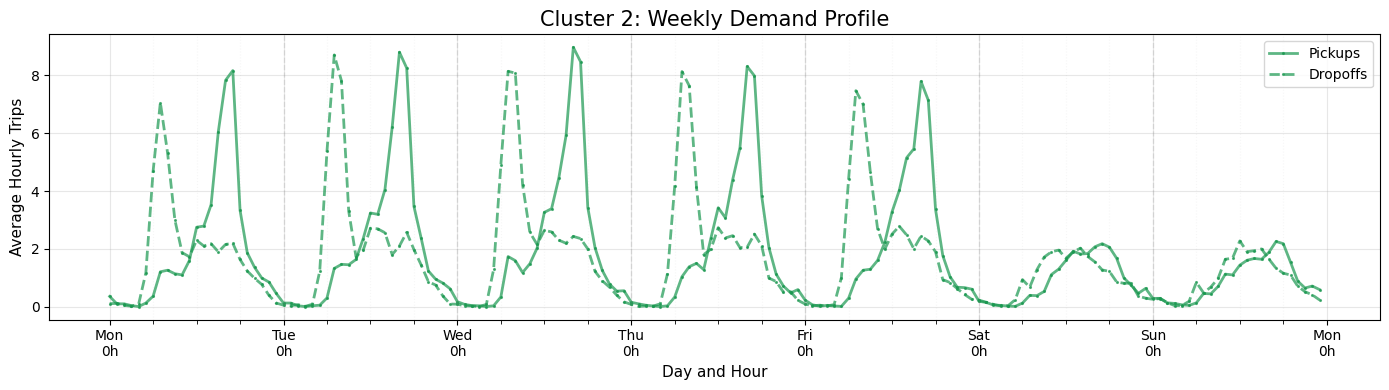

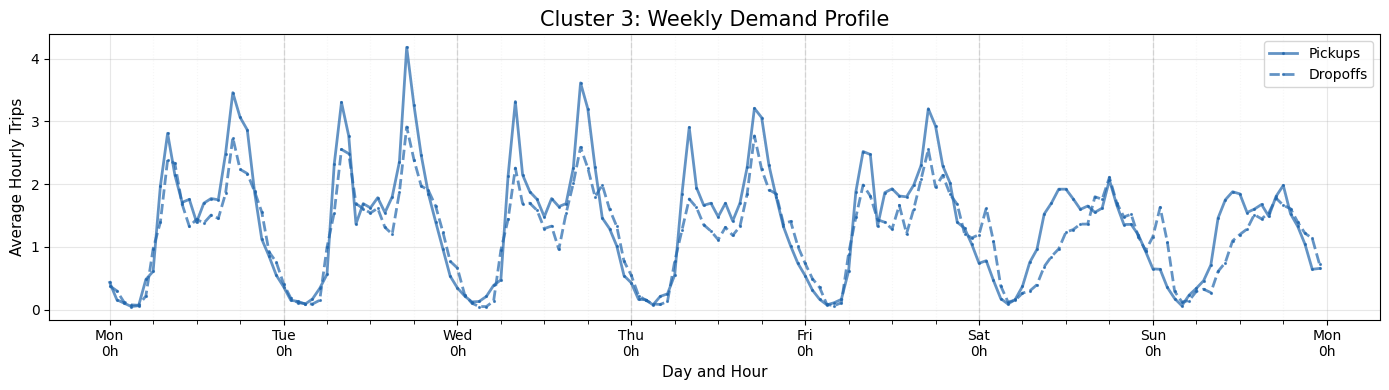

In [19]:
rnd.seed(42)

n_clusters = len(set(clusters.values()))
comparison_df = rnd_weekly_df.copy()[["dayofweek", "hour"]]

for idx in range(n_clusters):
    cluster_sid = [sid for sid, cid in clusters.items() if cid == idx]
    n_sid_in_cluster = len(cluster_sid)

    rnd_idx_in_cluster = rnd.randint(0, n_sid_in_cluster - 1)  # Fixed: 0-indexed, inclusive upper bound
    rnd_sid_in_cluster = cluster_sid[rnd_idx_in_cluster]

    rnd_weekly_df_in_cluster = weekly_df_dict[rnd_sid_in_cluster].copy()
    rnd_weekly_df_in_cluster = rnd_weekly_df_in_cluster.rename(
        columns={
            "avg_pickups": f"C{idx}_avg_pickups",
            "avg_dropoffs": f"C{idx}_avg_dropoffs"
        }
    )

    comparison_df = comparison_df.merge(
        rnd_weekly_df_in_cluster[["dayofweek", "hour", f"C{idx}_avg_pickups", f"C{idx}_avg_dropoffs"]], 
        on=["dayofweek", "hour"],
        how="left"
    )

cluster_colors = [COLORS[1], COLORS[3], COLORS[5], COLORS[7]]
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

for idx, (color, name) in enumerate(zip(cluster_colors, cluster_names)):
    plot_hourly_weekly(
        comparison_df,
        columns_to_plot=[f'C{idx}_avg_pickups', f'C{idx}_avg_dropoffs'],
        title=f'{name}: Weekly Demand Profile',
        xlabel='Day and Hour',
        ylabel='Average Hourly Trips',
        color_list=[color, color],
        linestyle_list=['-', '--'],
        legend_labels=['Pickups', 'Dropoffs'],
        figsize=(14,4)
    )

---

Lets define our period of interest

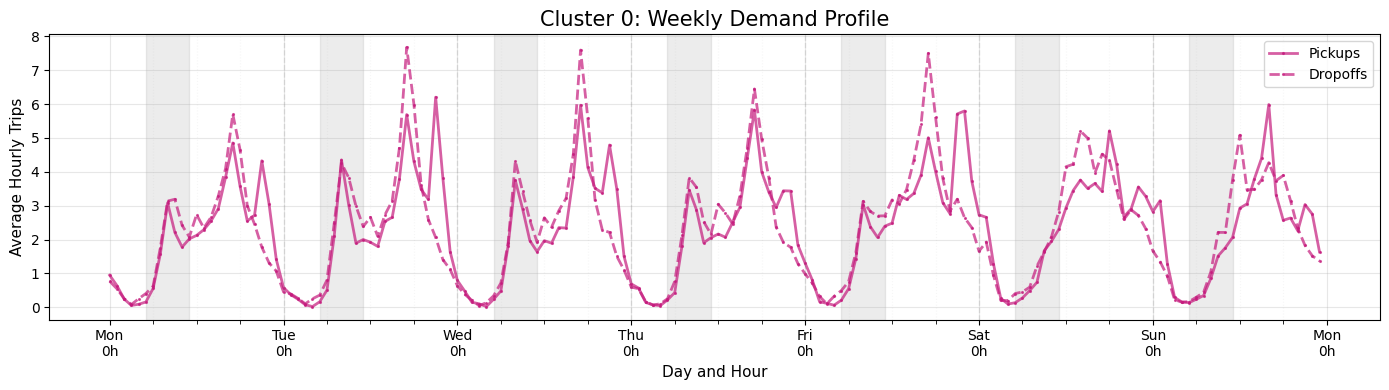

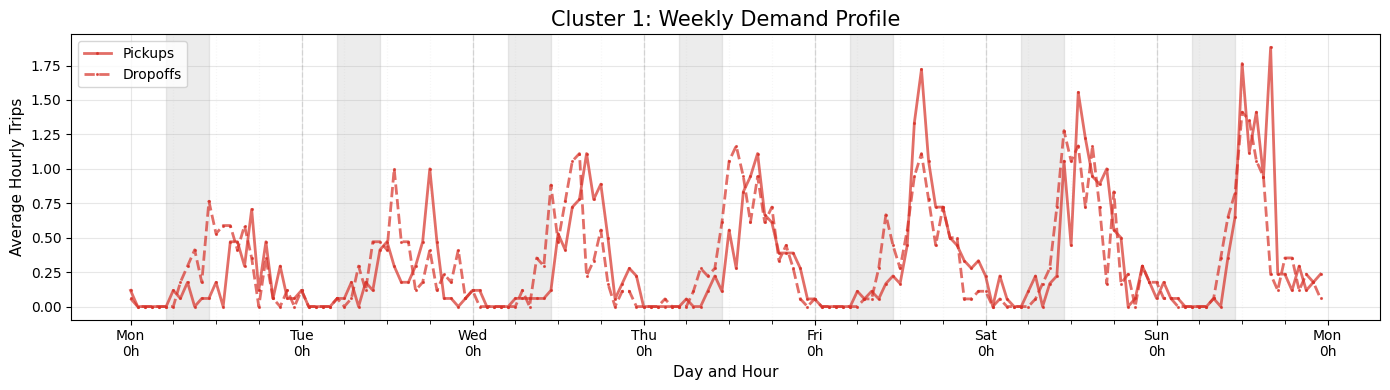

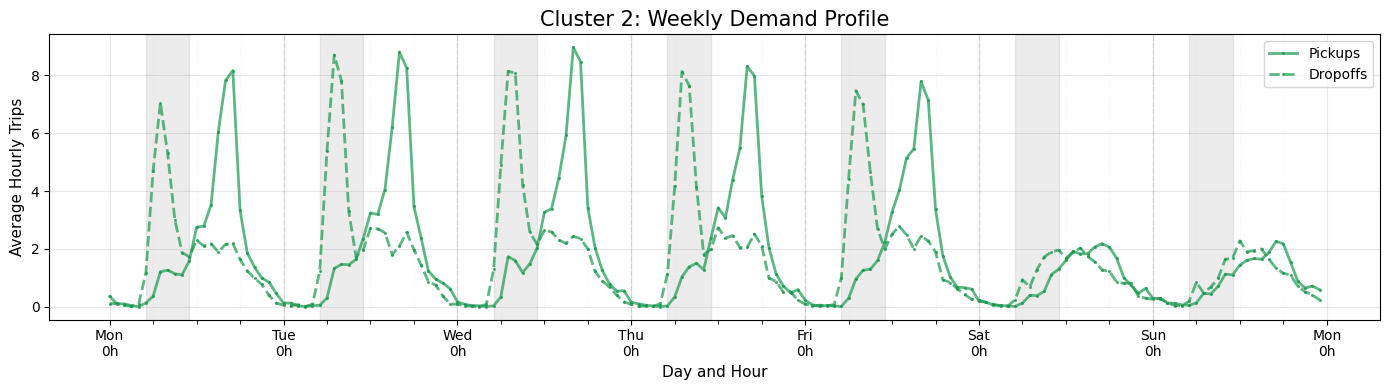

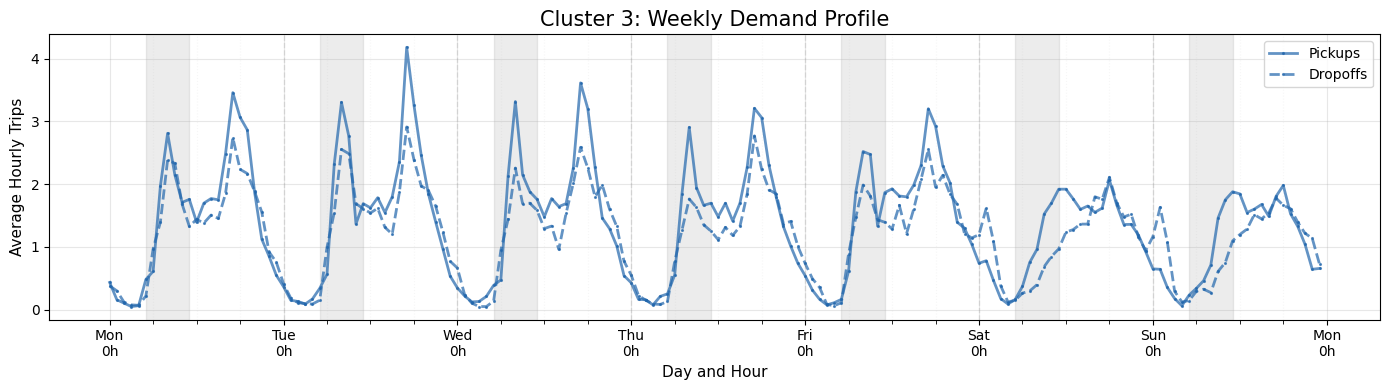

In [20]:
for idx, (color, name) in enumerate(zip(cluster_colors, cluster_names)):
    plot_hourly_weekly(
        comparison_df,
        columns_to_plot=[f'C{idx}_avg_pickups', f'C{idx}_avg_dropoffs'],
        title=f'{name}: Weekly Demand Profile',
        xlabel='Day and Hour',
        ylabel='Average Hourly Trips',
        color_list=[color, color],
        linestyle_list=['-', '--'],
        legend_labels=['Pickups', 'Dropoffs'],
        figsize=(14,4),
        shade_hours=(5, 11)
    )

The 6h period between 5am and 11am seems like a reasonable demand to predict and for which to perform the rebalancing proactive tasks.

---

Lets aggregate at that time of the day and generate individual time series based on daily morning demand per station.

In [21]:
# Get full date range from df_hourly
min_date = df_hourly["date"].min()
max_date = df_hourly["date"].max()
full_date_range = pd.date_range(start=min_date, end=max_date, freq='D').date

morning_demand_dict = {}

for station_id, df in station_df_dict.items():
    # Filter to morning hours (5am-10:59am)
    df_morning = df[df['timestamp'].dt.hour.between(5, 10)].copy()
    
    # Extract date and aggregate
    df_morning['date'] = df_morning['timestamp'].dt.date
    daily_morning = df_morning.groupby('date')[['pickups', 'dropoffs']].sum().reset_index()
    daily_morning.columns = ['date', 'morning_pickups', 'morning_dropoffs']
    
    # Reindex to include all dates (fills missing with NaN)
    daily_morning = daily_morning.set_index('date')
    daily_morning = daily_morning.reindex(full_date_range, fill_value=0)  # Or use fill_value=np.nan
    
    morning_demand_dict[station_id] = daily_morning

In [22]:
morning_demand_dict[station_id].head()

morning_pickups  morning_dropoffs
date                                         
2023-04-01                0                 0
2023-04-02                0                 0
2023-04-03                0                 0
2023-04-04                0                 0
2023-04-05                0                 0

In [23]:
rnd.seed(42)

n_clusters = len(set(clusters.values()))

# Get a reference station to extract date index
rnd_station_id = list(morning_demand_dict.keys())[0]
comparison_df = morning_demand_dict[rnd_station_id].index.to_frame(index=False, name='date')

for idx in range(n_clusters):
    cluster_sid = [sid for sid, cid in clusters.items() if cid == idx]
    n_sid_in_cluster = len(cluster_sid)

    rnd_idx_in_cluster = rnd.randint(0, n_sid_in_cluster - 1)
    rnd_sid_in_cluster = cluster_sid[rnd_idx_in_cluster]

    rnd_morning_df = morning_demand_dict[rnd_sid_in_cluster].copy().reset_index()
    rnd_morning_df = rnd_morning_df.rename(
        columns={
            "morning_pickups": f"C{idx}_morning_pickups",
            "morning_dropoffs": f"C{idx}_morning_dropoffs"
        }
    )

    comparison_df = comparison_df.merge(
        rnd_morning_df[["date", f"C{idx}_morning_pickups", f"C{idx}_morning_dropoffs"]], 
        on="date",
        how="left"
    )

# Set date as index for plotting
comparison_df = comparison_df.set_index('date')

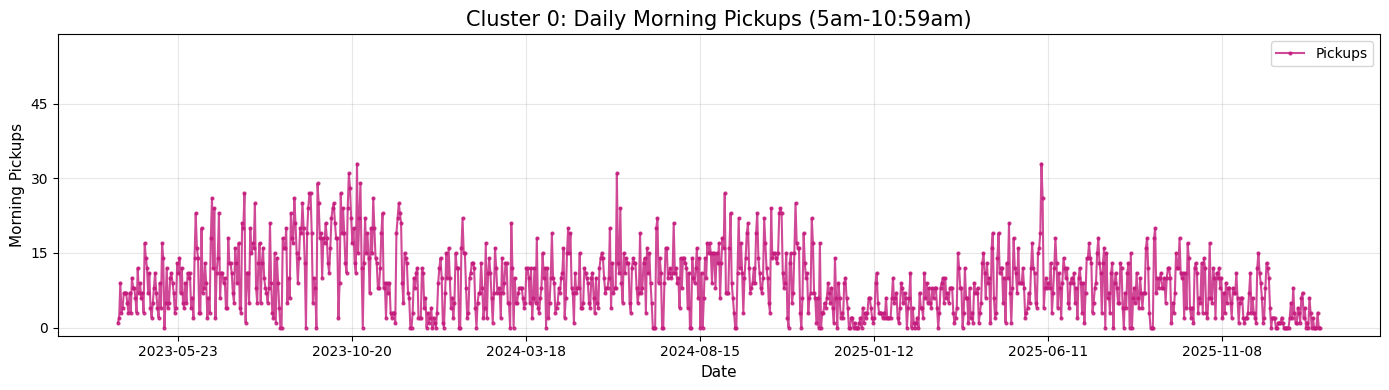

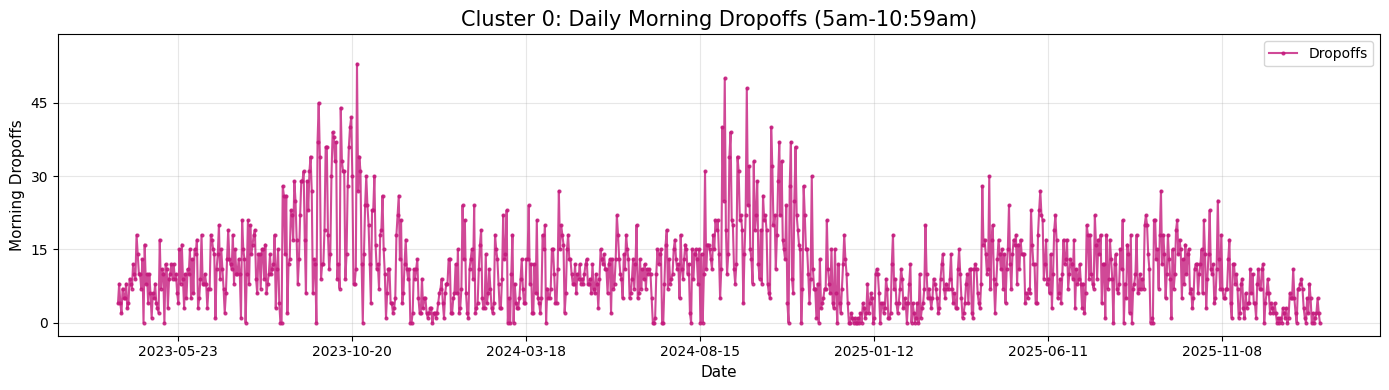

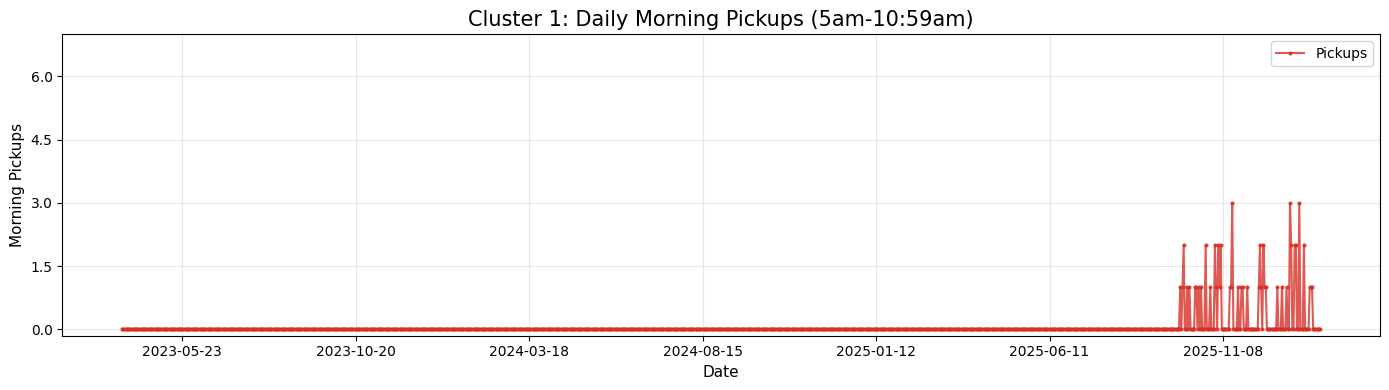

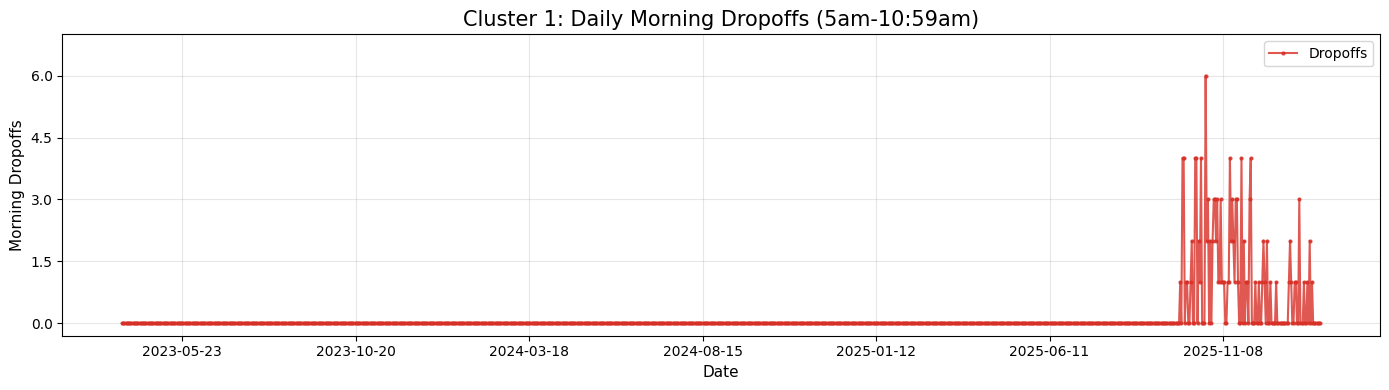

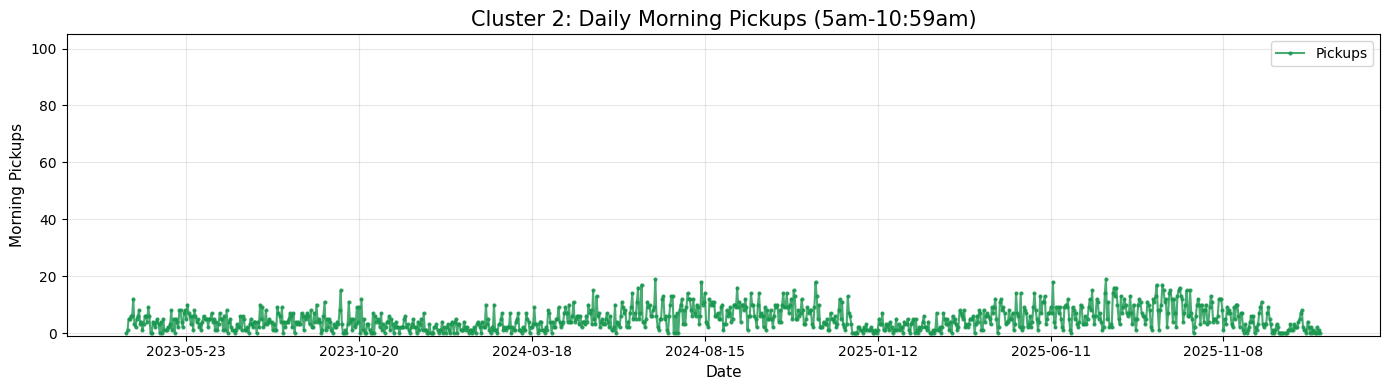

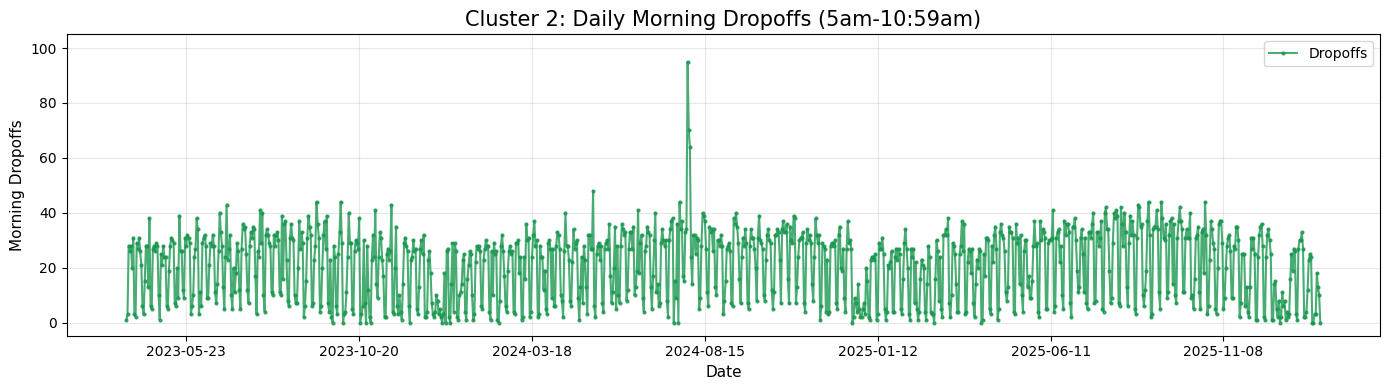

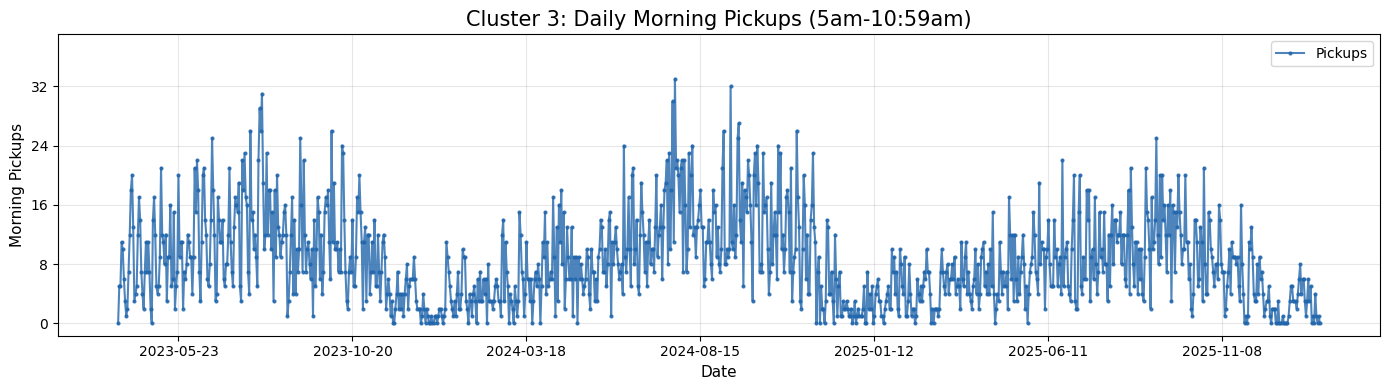

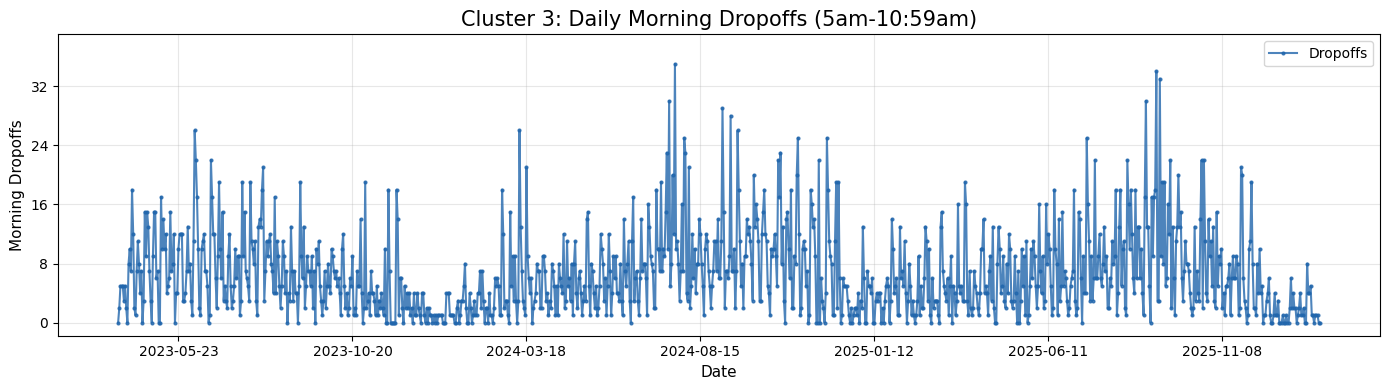

In [26]:
cluster_colors = [COLORS[1], COLORS[3], COLORS[5], COLORS[7]]
cluster_names = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"]

# Plot pickups for all clusters
for idx, (color, name) in enumerate(zip(cluster_colors, cluster_names)):
    pickup_col = f"C{idx}_morning_pickups"
    dropoff_col = f"C{idx}_morning_dropoffs"

    y_max = max(comparison_df[pickup_col].max(), comparison_df[dropoff_col].max())
    y_max = np.ceil(1.1 * y_max)

    plot_daily_longterm(
        comparison_df,
        columns_to_plot=[pickup_col],
        title=f"{name}: Daily Morning Pickups (5am-10:59am)",
        xlabel="Date",
        ylabel="Morning Pickups",
        color_list=[color],
        legend_labels=["Pickups"],
        figsize=(14, 4),
        ylim_max=y_max,
    )

    plot_daily_longterm(
        comparison_df,
        columns_to_plot=[dropoff_col],
        title=f"{name}: Daily Morning Dropoffs (5am-10:59am)",
        xlabel="Date",
        ylabel="Morning Dropoffs",
        color_list=[color],
        legend_labels=["Dropoffs"],
        figsize=(14, 4),
        ylim_max=y_max,
    )